In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from tqdm.auto import tqdm
import random

/home/andreisemenov/anaconda3/envs/secondord/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def smooth(a, eps=0.01):
    b = [a[0]]
    for e in a[1:]:
        b.append(b[-1] * (1 - eps) + e * eps)
    return b

In [3]:
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)


def set_device(device_no: int):
    if torch.cuda.is_available():
        device = torch.device(f"cuda:{device_no}")
        print("There are %d GPU(s) available." % torch.cuda.device_count())
        print("We will use the GPU:", torch.cuda.get_device_name(device_no))
    else:
        print("No GPU available, using the CPU instead.")
        device = torch.device("cpu")

    return device

In [4]:
def plot_norms(
        grad_norms_array: str, 
        hess_norms_array: str, 
        title: str,
        M_constant: float = 1,
        plot_with_percentiles: bool = True,
        logscale: bool = False,
        do_smooth: bool =True,
    ):

    loaded_grad_norms_arr = np.load(grad_norms_array)
    loaded_hess_hutch_norm_diffs_arr = np.load(hess_norms_array)

    if do_smooth:
        loaded_grad_norms_arr = [smooth(l) for l in list(loaded_grad_norms_arr)]
        loaded_hess_hutch_norm_diffs_arr = [smooth(l) for l in list(loaded_hess_hutch_norm_diffs_arr)]

    plot_grad_norms_arr = np.sqrt(loaded_grad_norms_arr)
    plot_hess_hutch_norm_diffs_arr = M_constant * np.array(loaded_hess_hutch_norm_diffs_arr)

    gradp50 = np.percentile(plot_grad_norms_arr, 50, axis=0)
    hessp50 = np.percentile(plot_hess_hutch_norm_diffs_arr, 50, axis=0)

    plt.figure(figsize=(16, 8) ,dpi=150)

    if logscale:
        if plot_with_percentiles:
            gradp10 = np.percentile(plot_grad_norms_arr, 10, axis=0)
            gradp90 = np.percentile(plot_grad_norms_arr, 90, axis=0)
            hessp10 = np.percentile(plot_hess_hutch_norm_diffs_arr, 10, axis=0)
            hessp90 = np.percentile(plot_hess_hutch_norm_diffs_arr, 90, axis=0)

            plt.loglog(gradp50, label=r'$\|\nabla f\|^{1/2}$', color='b', linewidth=0.5)
            plt.fill_between(range(len(loaded_grad_norms_arr[0])), gradp10, gradp90, color='b', alpha=0.2)

            plt.loglog(hessp50, label=r'$\| H - \nabla^2 f\|$', color='g', linewidth=0.5)
            plt.fill_between(range(len(loaded_grad_norms_arr[0])), hessp10, hessp90, color='g', alpha=0.2)
        else:
            plt.loglog(gradp50, label=r'$\|\nabla f\|^{1/2}$', color='b', linewidth=0.5)
            plt.loglog(hessp50, label=r'$\| H - \nabla^2 f\|$', color='g', linewidth=0.5)
            
    else:
        if plot_with_percentiles:
            gradp10 = np.percentile(plot_grad_norms_arr, 10, axis=0)
            gradp90 = np.percentile(plot_grad_norms_arr, 90, axis=0)
            hessp10 = np.percentile(plot_hess_hutch_norm_diffs_arr, 10, axis=0)
            hessp90 = np.percentile(plot_hess_hutch_norm_diffs_arr, 90, axis=0)

            plt.plot(gradp50, label=r'$\|\nabla f\|^{1/2}$', color='b', linewidth=0.5)
            plt.fill_between(range(len(loaded_grad_norms_arr[0])), gradp10, gradp90, color='b', alpha=0.2)

            plt.plot(hessp50, label=r'$\| H - \nabla^2 f\|$', color='g', linewidth=0.5)
            plt.fill_between(range(len(loaded_grad_norms_arr[0])), hessp10, hessp90, color='g', alpha=0.2)
        else:
            plt.plot(gradp50, label=r'$\|\nabla f\|^{1/2}$', color='b', linewidth=0.5)
            plt.plot(hessp50, label=r'$\| H - \nabla^2 f\|$', color='g', linewidth=0.5)

    plt.title(title, fontsize=40, fontweight='bold')
    plt.xlabel('Number of Iterations', fontsize=45)
    plt.ylabel('Norm', fontsize=45)
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.legend(loc='best', fontsize=20)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    plt.tight_layout()
    plt.show()

In [74]:
def plot_relative_inexactness(
        grad_norms_array: str, 
        hess_norms_array: str, 
        title: str,
        M_constant: float = 1,
        plot_with_percentiles: bool = True,
        logscale: bool = False,
        do_smooth: bool =True,
    ):
    loaded_grad_norms_arr = np.load(grad_norms_array)
    loaded_hess_hutch_norm_diffs_arr = np.load(hess_norms_array)

    if do_smooth:
        loaded_grad_norms_arr = [smooth(l) for l in list(loaded_grad_norms_arr)]
        loaded_hess_hutch_norm_diffs_arr = [smooth(l) for l in list(loaded_hess_hutch_norm_diffs_arr)]
        
    relative_inexactness = M_constant * np.array(loaded_hess_hutch_norm_diffs_arr) / np.sqrt(loaded_grad_norms_arr)
    p50 = np.percentile(relative_inexactness, 50, axis=0)
    plt.figure(figsize=(16, 8) ,dpi=150)
    
    if plot_with_percentiles == False:
        if logscale:
            plt.loglog(p50, label=r'Relative Inexactness', color='r', linewidth=0.5)
        else:
            plt.plot(p50, label=r'Relative Inexactness', color='r', linewidth=0.5)
    else:
        p10 = np.percentile(relative_inexactness, 10, axis=0)
        p90 = np.percentile(relative_inexactness, 90, axis=0)
        if logscale:
            plt.loglog(p50, label=r'Relative Inexactness', color='r', linewidth=0.5)
        else:
            plt.plot(p50, label=r'Relative Inexactness', color='r', linewidth=0.5)
        plt.fill_between(range(len(loaded_grad_norms_arr[0])), p10, p90, color='r', alpha=0.2)

    plt.title(title, fontsize=40, fontweight='bold')
    plt.xlabel('Number of Iterations', fontsize=45)
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.legend(loc='best', fontsize=20)
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)
    plt.tight_layout()
    plt.show()

In [6]:
class MLPModel(nn.Module):
    def __init__(self):
        super(MLPModel, self).__init__()
        self.fc1 = nn.Linear(28 * 28, 128, bias=False)
        self.fc2 = nn.Linear(128, 64, bias=False)
        self.fc3 = nn.Linear(64, 10, bias=False)

    def forward(self, x):
        x = x.view(-1, 28 * 28)
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [7]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)
test_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=False)

In [47]:
def compute_fisher_and_hessian(model, data, target, loss_fn):
    N = data.size(0)
    device = next(model.parameters()).device
    num_params = sum(p.numel() for p in model.fc3.parameters())
    fisher_matrix = torch.zeros(num_params, num_params).to(device)
    hessian_matrix = torch.zeros(num_params, num_params).to(device)

    model.zero_grad()

    output = model(data)
    loss = loss_fn(output, target)

    grads = torch.autograd.grad(loss, model.fc3.parameters(), create_graph=True)[0]
    grad = torch.cat([g.view(-1) for g in grads])

    fisher_matrix += grad.unsqueeze(1) @ grad.unsqueeze(0)

    for j in range(num_params):
        grad_grad = torch.autograd.grad(grad[j], model.fc3.parameters(), retain_graph=True)
        hessian_matrix[j] += torch.cat([g.contiguous().view(-1) for g in grad_grad])

    fisher_matrix /= N
    hessian_matrix /= N

    return grads, fisher_matrix, hessian_matrix

In [48]:
def full_loop_mlp(model, train_loader, test_loader, device, num_epochs=10, lr=1e-3, norm_order=2):
    train_losses, grad_norms, hess_norms_diff, accuracy_arr= [], [], [], []
    loss_fn = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, amsgrad=True)
  
    for epoch in tqdm(range(num_epochs)):
        model.train()
        for step, (images, labels) in enumerate(train_loader):
            optimizer.zero_grad()
            images, labels = images.to(device), labels.to(device)
            output = model(images)
            loss = loss_fn(output, labels)
            loss.backward()
            train_losses.append(loss.item())
            optimizer.step()

            grads, fisher, hessian = compute_fisher_and_hessian(model, images, labels, loss_fn)
            grad_norms.append(torch.norm(grads, p=norm_order).detach().item())
            hess_norms_diff.append(torch.norm(fisher - hessian, p=norm_order).detach().item())

        print(f"Epoch {epoch}, Loss: {train_losses[-1]}")
        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        
        accuracy = 100 * correct / total
        accuracy_arr.append(accuracy)
        print(f'Eval Accuracy: {accuracy:.2f}%')

    print("Finished Training")
    return train_losses, grad_norms, hess_norms_diff, accuracy_arr

In [50]:
device = set_device(0)

There are 8 GPU(s) available.
We will use the GPU: NVIDIA A100-SXM4-80GB


In [51]:
num_runs = 5
all_grad_norms_fisher_mlp = []
all_hess_norms_fisher_mlp = []
all_train_losses_fisher_mlp = []
all_accuracy_arr_fisher_mlp = []

In [53]:
%%time
for run in range(num_runs):
    model = MLPModel().to(device)
    train_losses, grad_norms, hess_norms_diff, accuracy_arr = full_loop_mlp(model, train_loader, test_loader, device, num_epochs=2, lr=1e-3, norm_order=2)
    all_grad_norms_fisher_mlp.append(grad_norms)
    all_hess_norms_fisher_mlp.append(hess_norms_diff)
    all_train_losses_fisher_mlp.append(train_losses)
    all_accuracy_arr_fisher_mlp.append(accuracy_arr)

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 0, Loss: 0.013130887411534786


 50%|█████     | 1/2 [08:39<08:39, 519.01s/it]

Eval Accuracy: 96.22%
Epoch 1, Loss: 0.0513429269194603


100%|██████████| 2/2 [16:53<00:00, 506.96s/it]


Eval Accuracy: 97.39%
Finished Training


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 0, Loss: 0.1201142892241478


 50%|█████     | 1/2 [09:09<09:09, 549.45s/it]

Eval Accuracy: 96.35%
Epoch 1, Loss: 0.2881433665752411


100%|██████████| 2/2 [18:10<00:00, 545.21s/it]


Eval Accuracy: 97.98%
Finished Training


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 0, Loss: 0.09765356034040451


 50%|█████     | 1/2 [08:20<08:20, 500.29s/it]

Eval Accuracy: 96.38%
Epoch 1, Loss: 0.19756467640399933


100%|██████████| 2/2 [16:34<00:00, 497.03s/it]


Eval Accuracy: 97.95%
Finished Training


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 0, Loss: 0.0975019559264183


 50%|█████     | 1/2 [08:40<08:40, 520.54s/it]

Eval Accuracy: 96.62%
Epoch 1, Loss: 0.2559345066547394


100%|██████████| 2/2 [17:23<00:00, 521.70s/it]


Eval Accuracy: 97.65%
Finished Training


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 0, Loss: 0.06924918293952942


 50%|█████     | 1/2 [08:42<08:42, 522.41s/it]

Eval Accuracy: 95.85%
Epoch 1, Loss: 0.19939807057380676


100%|██████████| 2/2 [18:50<00:00, 565.14s/it]

Eval Accuracy: 97.51%
Finished Training
CPU times: user 6h 5min 10s, sys: 4min 4s, total: 6h 9min 15s
Wall time: 1h 27min 52s


In [54]:
np.save('fisher_mnist_grad_norms.npy', all_grad_norms_fisher_mlp)
np.save('fisher_mnist_hess_norms.npy', all_hess_norms_fisher_mlp)

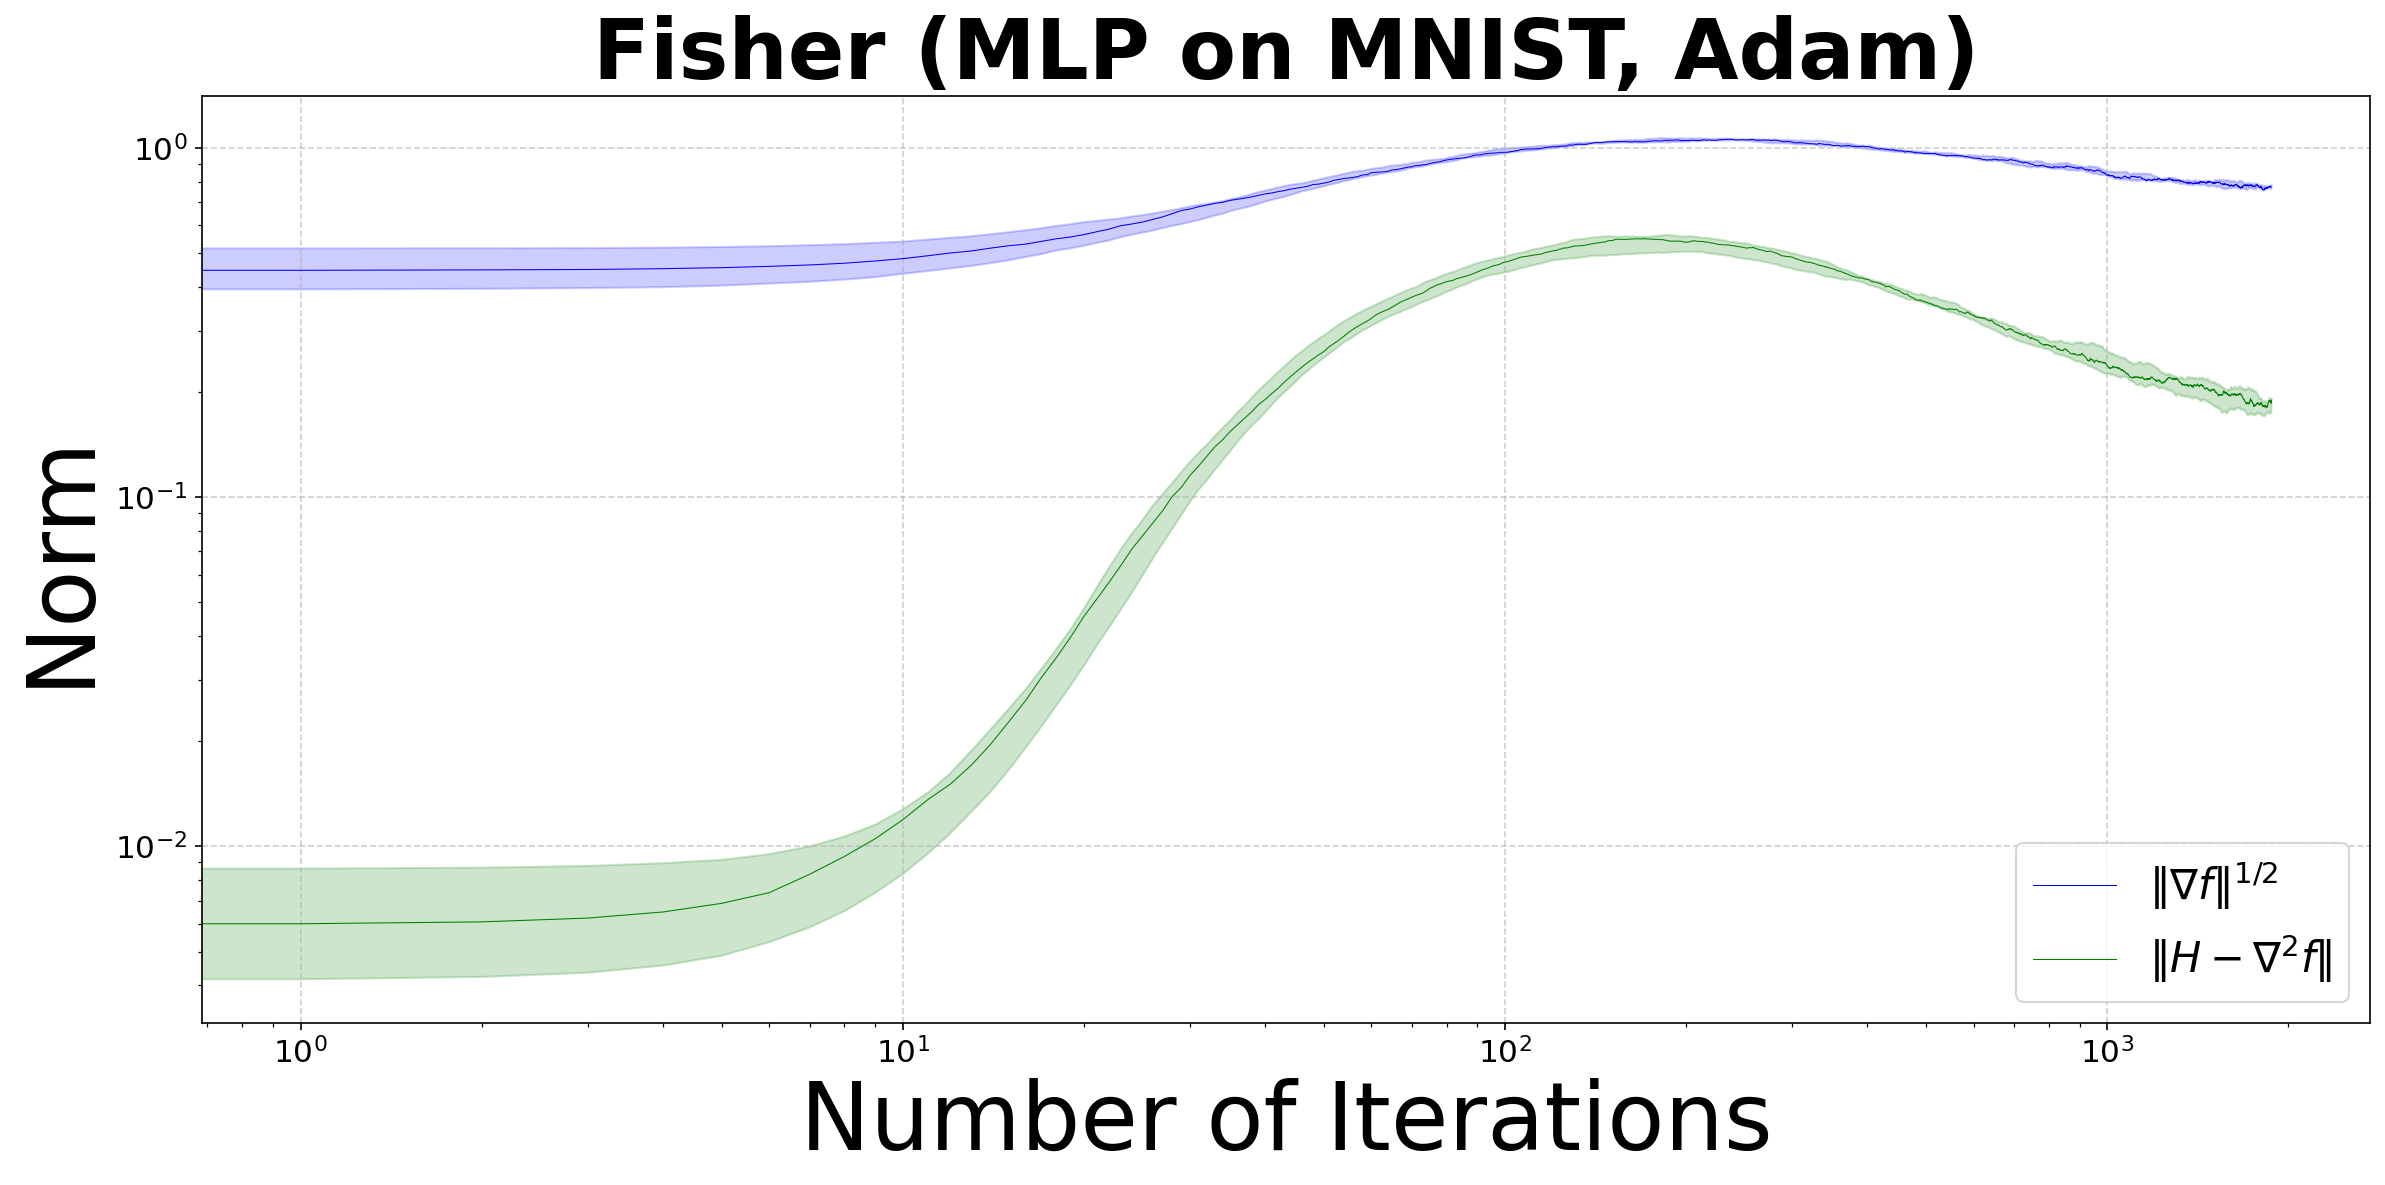

In [60]:
plot_norms(
    'fisher_mnist_grad_norms.npy', 
    'fisher_mnist_hess_norms.npy', 
    'Fisher (MLP on MNIST, Adam)',
    M_constant=1,
    plot_with_percentiles=True,
    logscale=True,
    )

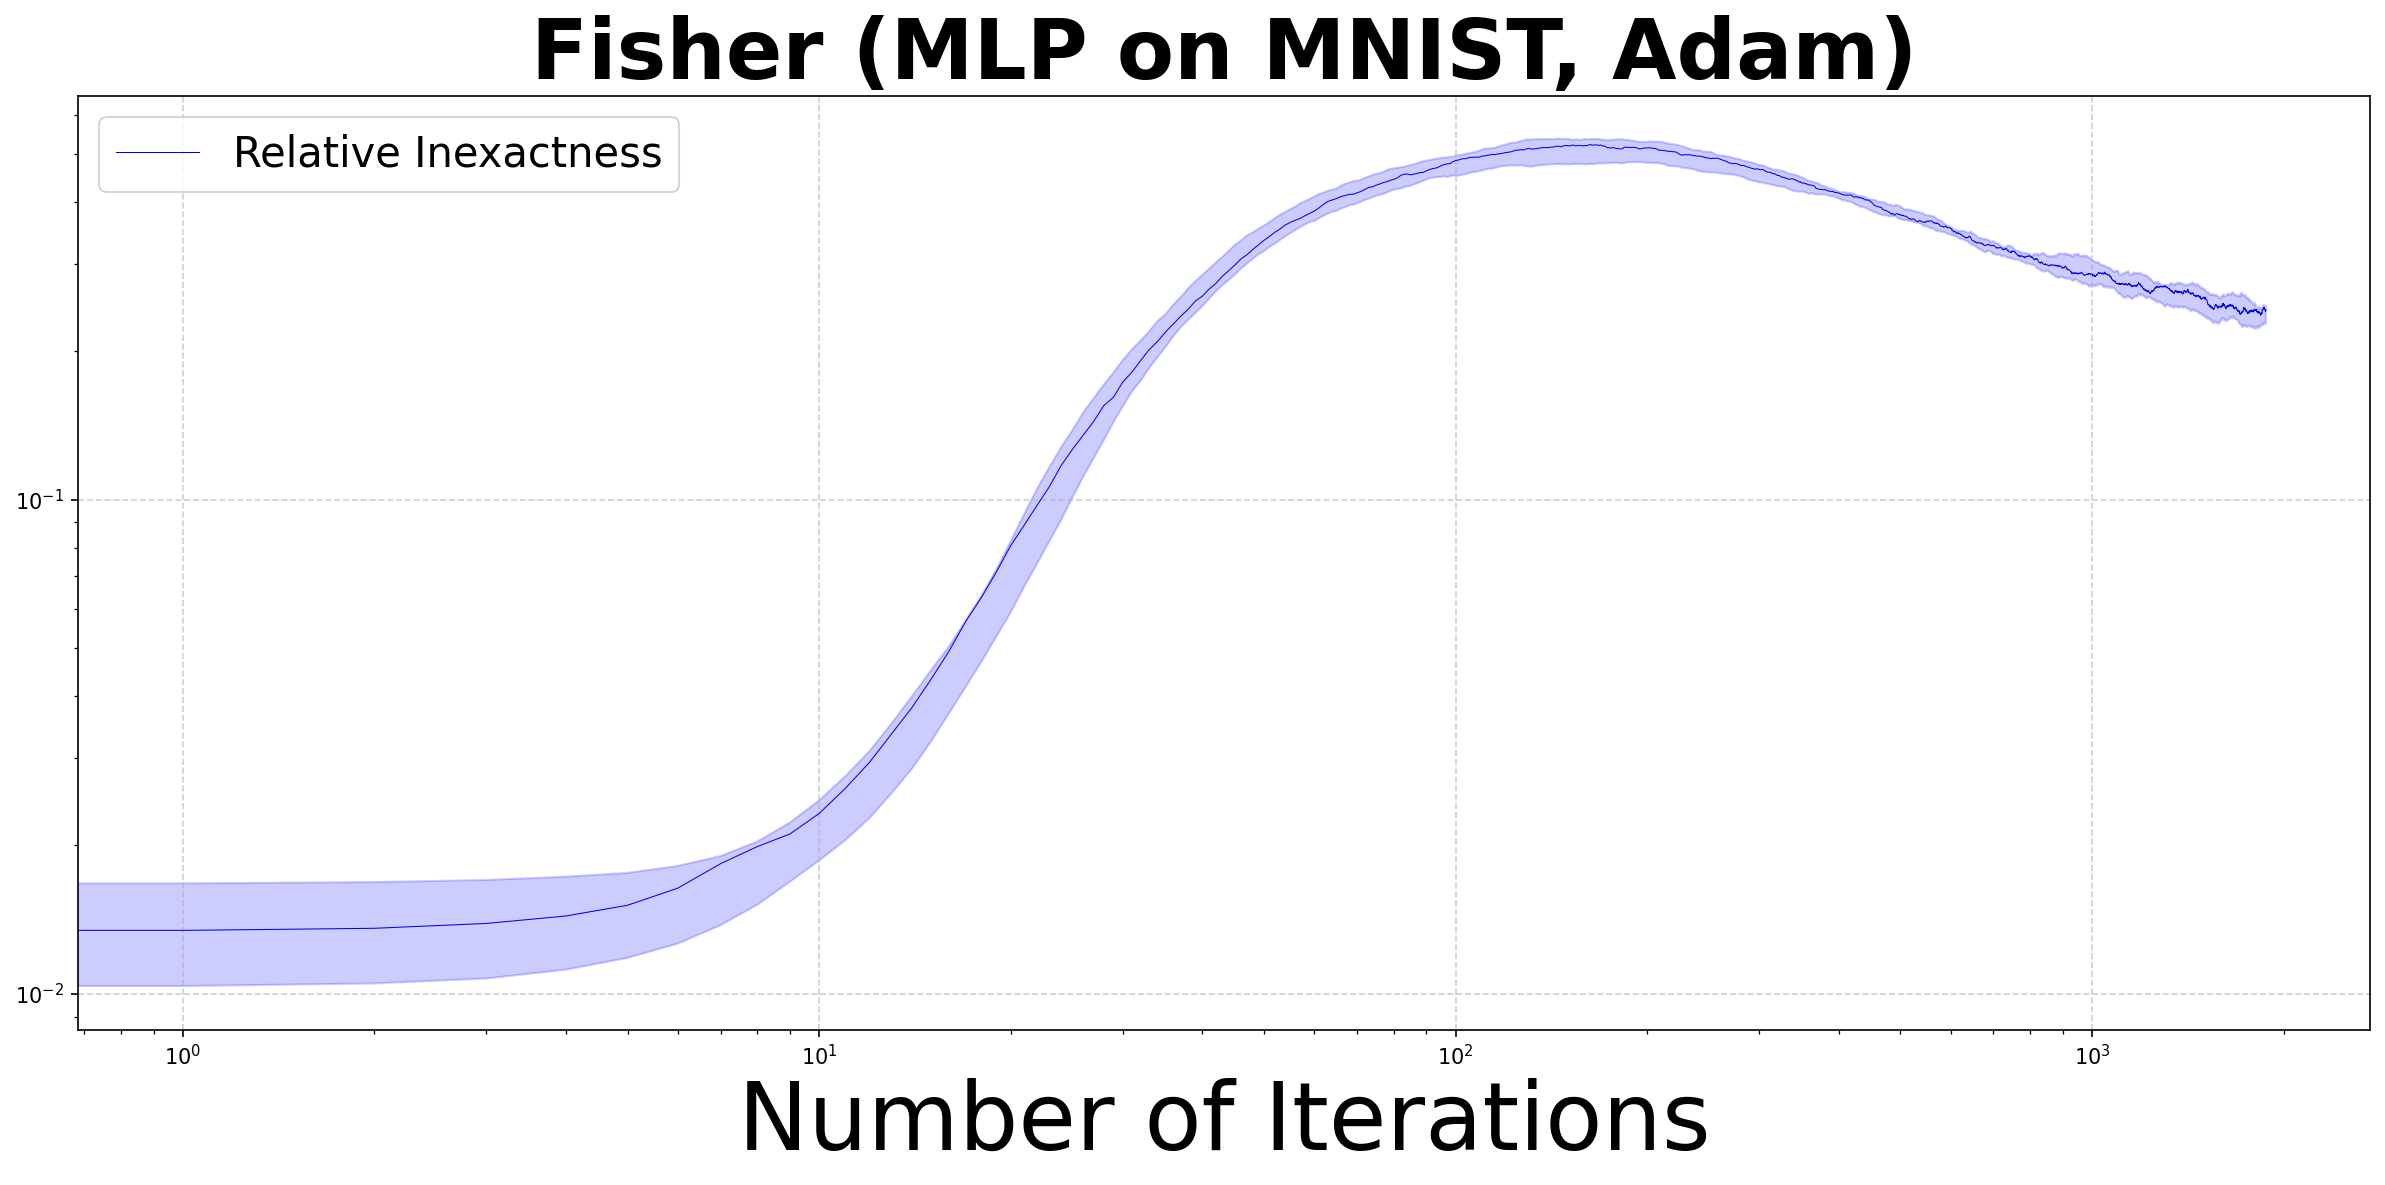

In [61]:
plot_relative_inexactness(
    'fisher_mnist_grad_norms.npy',
    'fisher_mnist_hess_norms.npy', 
    'Fisher (MLP on MNIST, Adam)',
    M_constant=1,
    plot_with_percentiles=True,
    logscale=True,
    )

### plotting of other stuff

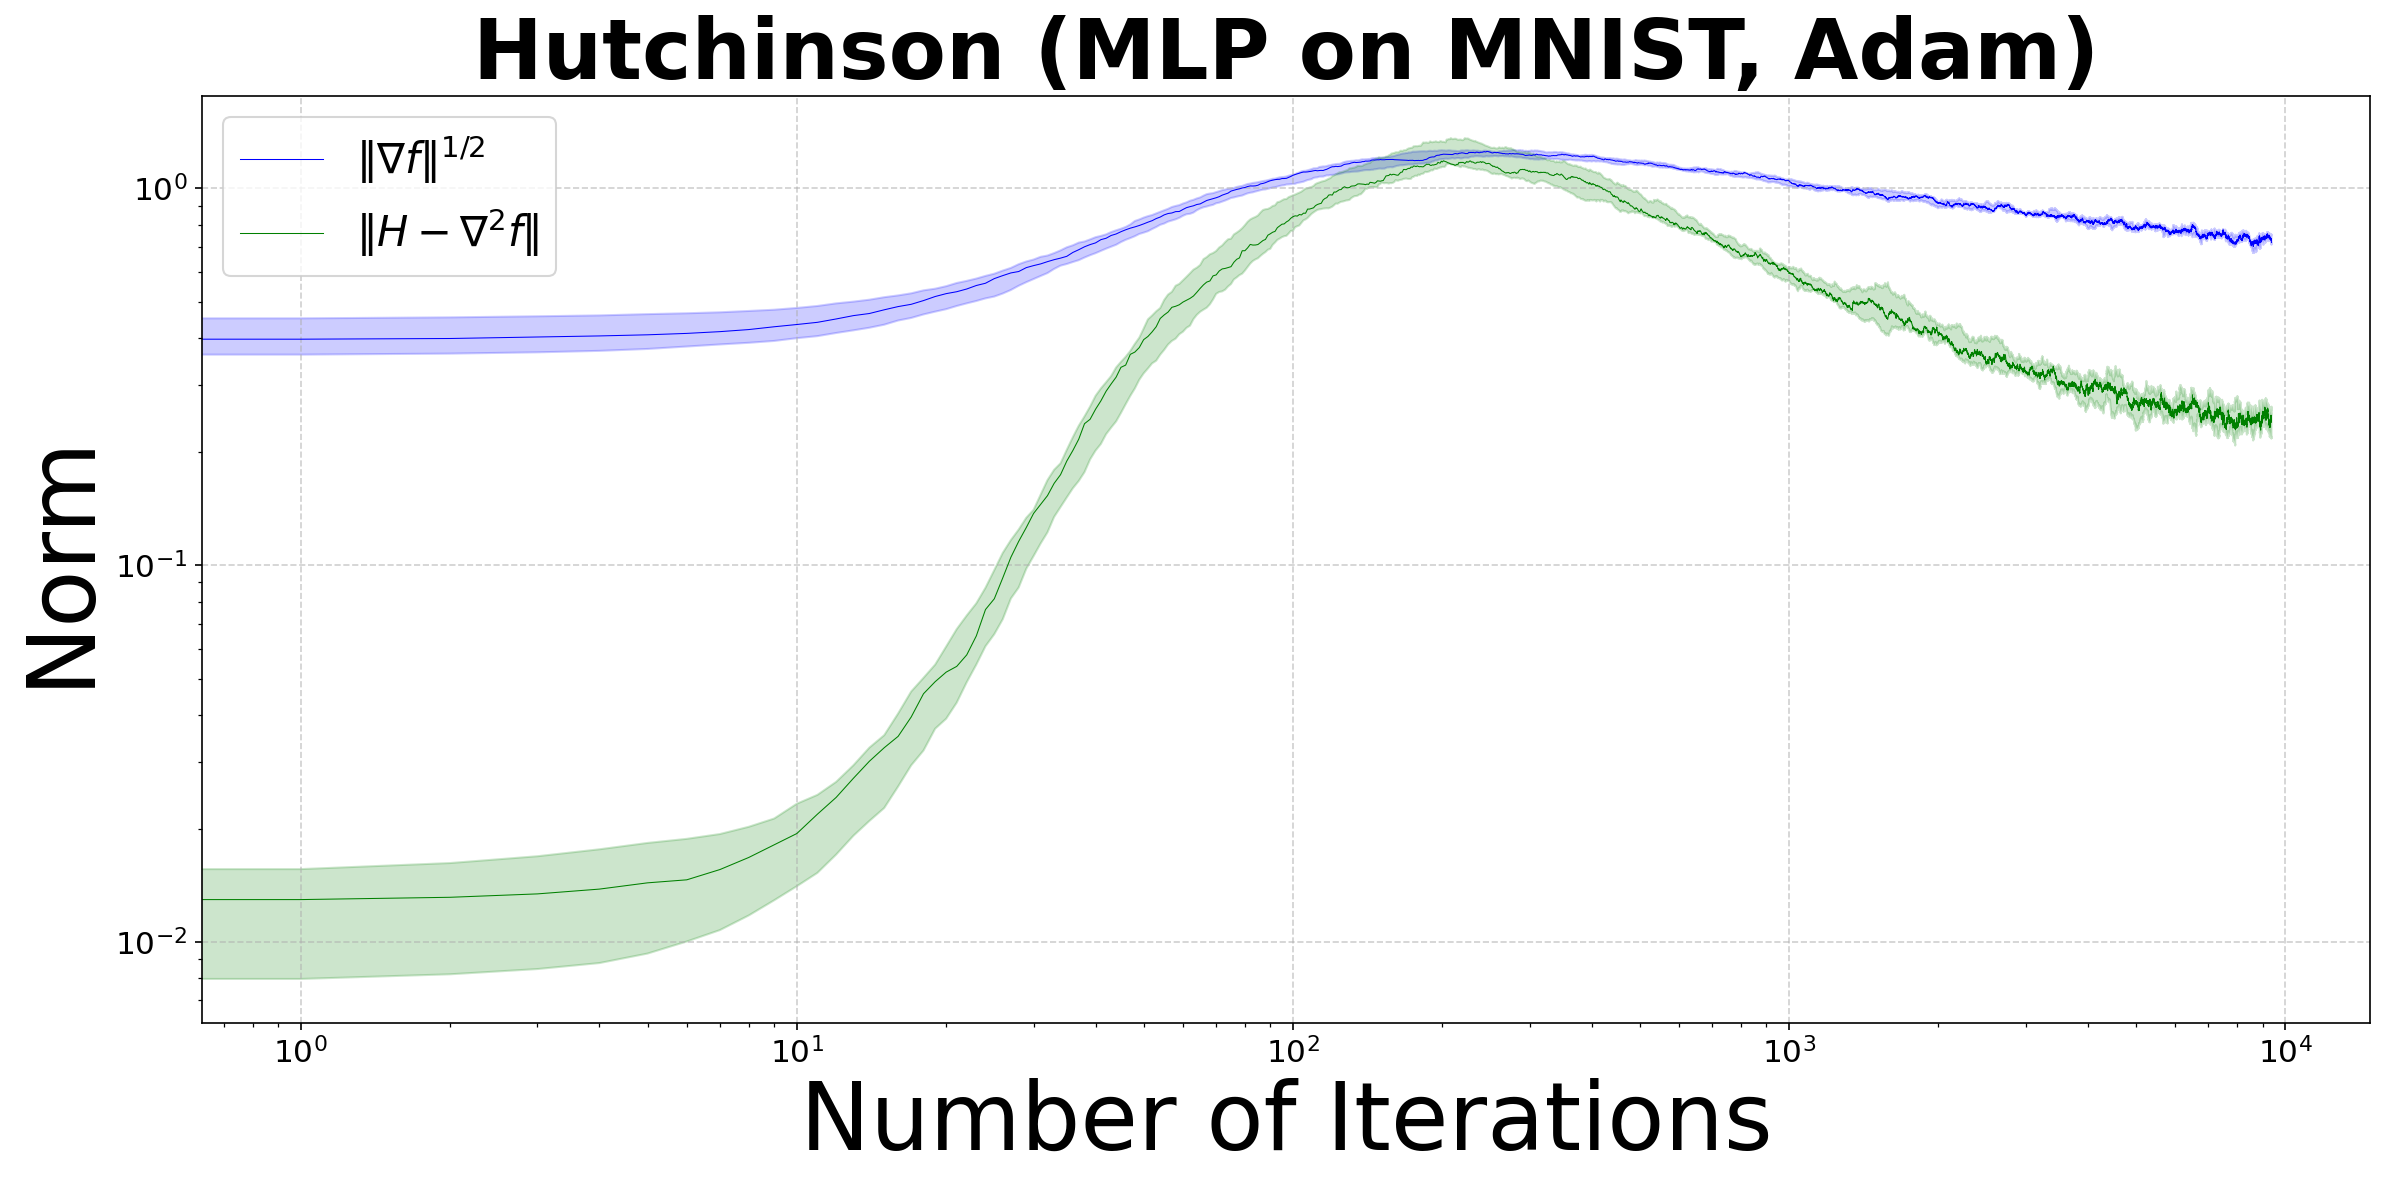

In [73]:
plot_norms(
    'hutch_mnist_mlp_grad_norms.npy', 
    'hutch_mnist_mlp_norms_diff.npy', 
    'Hutchinson (MLP on MNIST, Adam)',
    M_constant=1 / 40,
    plot_with_percentiles=True,
    logscale=True,
    )

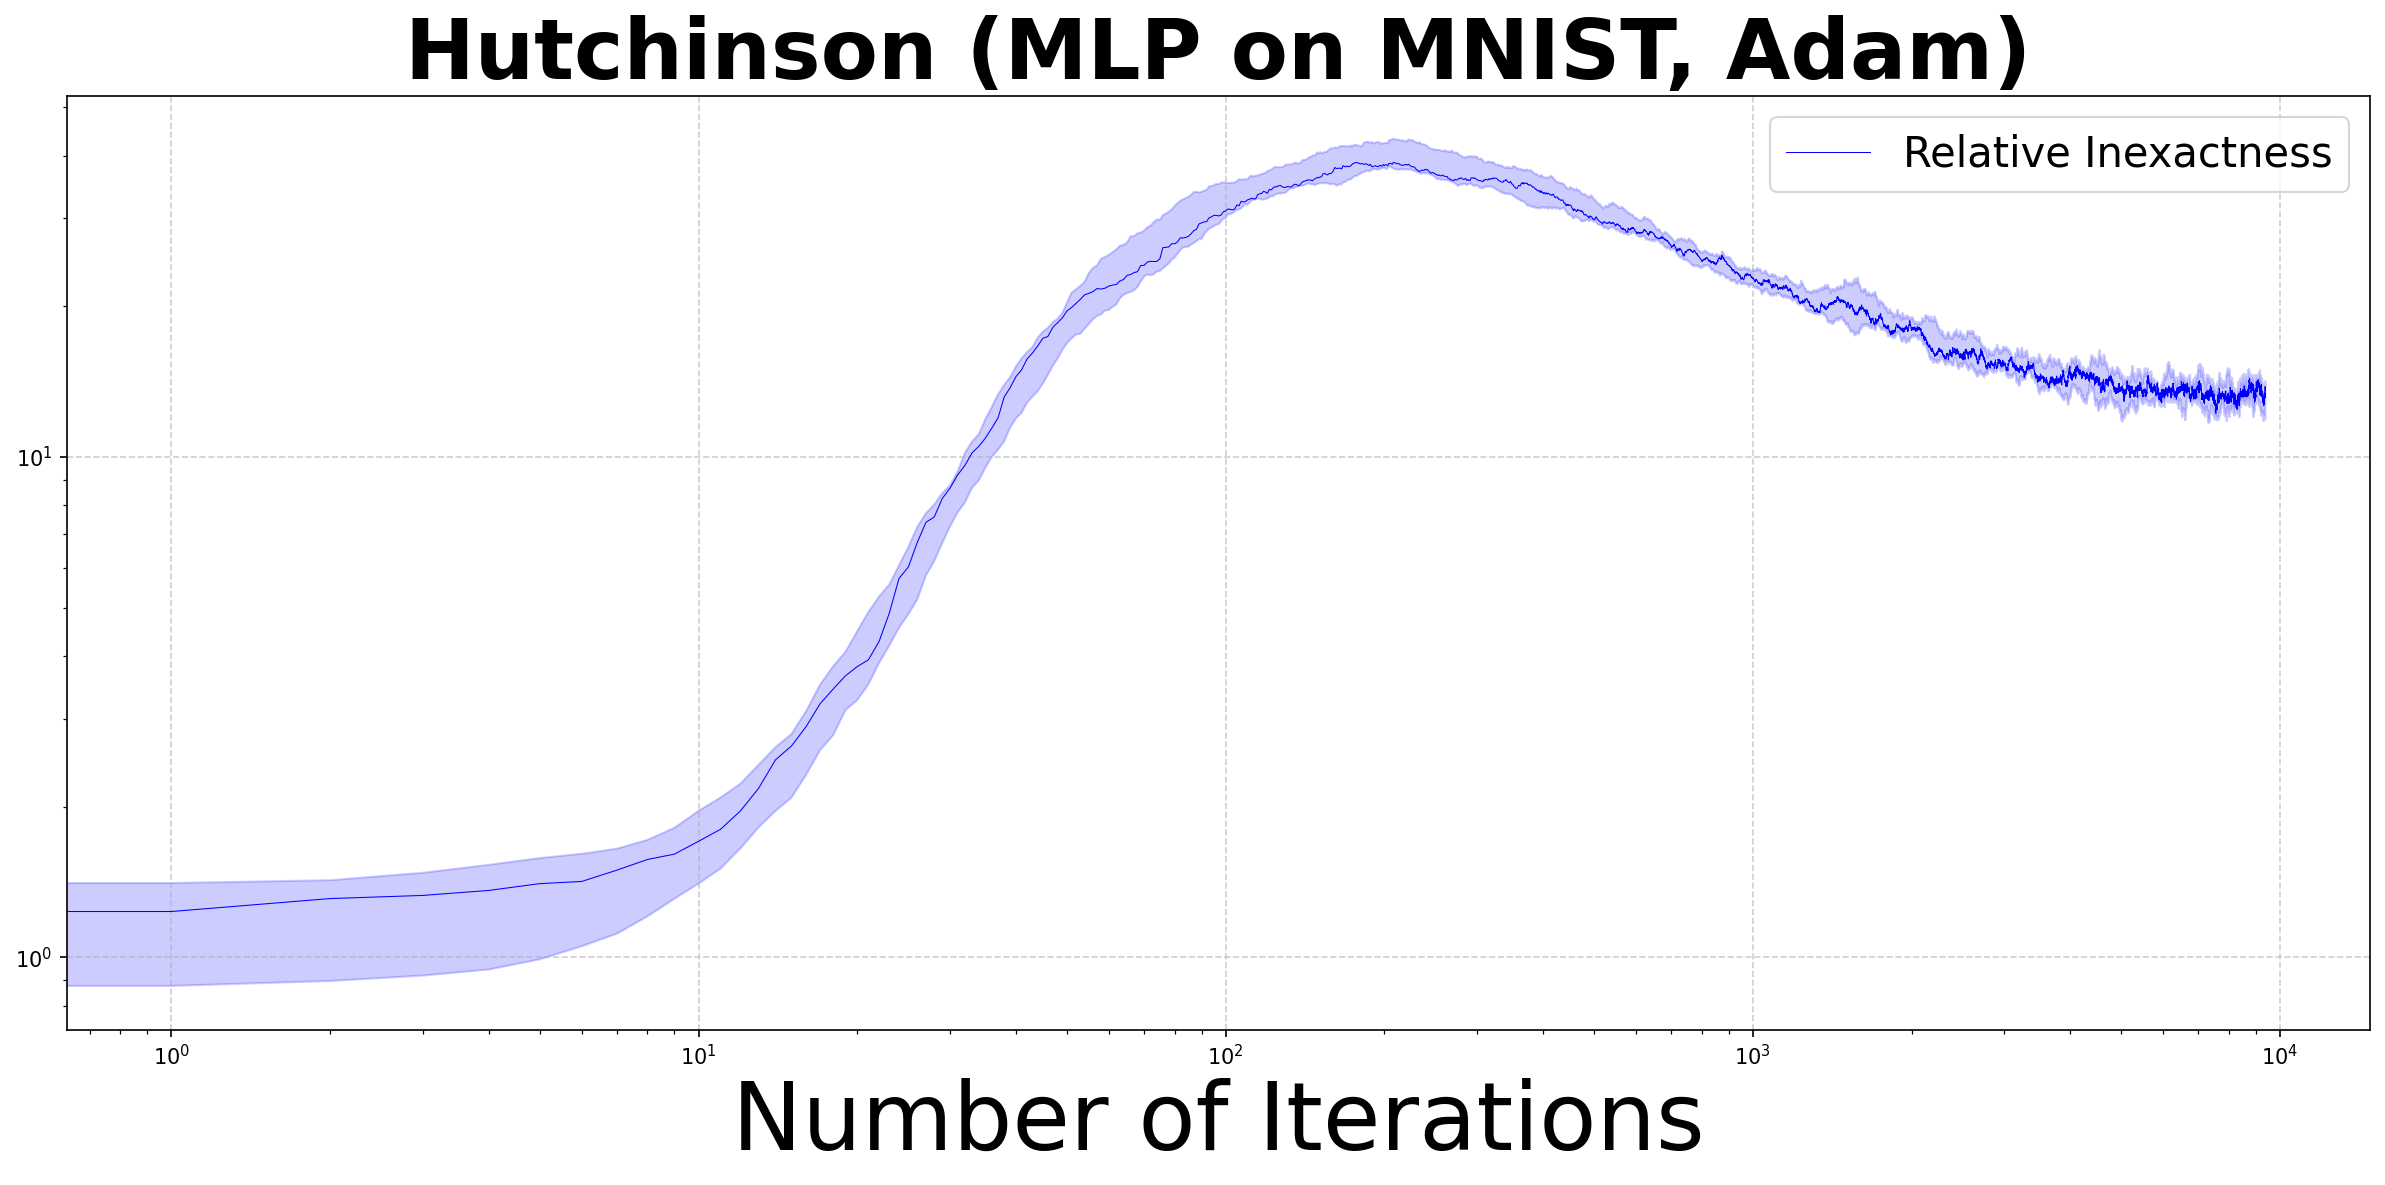

In [70]:
plot_relative_inexactness(
    'hutch_mnist_mlp_grad_norms.npy',
    'hutch_mnist_mlp_norms_diff.npy', 
    'Hutchinson (MLP on MNIST, Adam)',
    M_constant=1,
    plot_with_percentiles=True,
    logscale=True,
    )

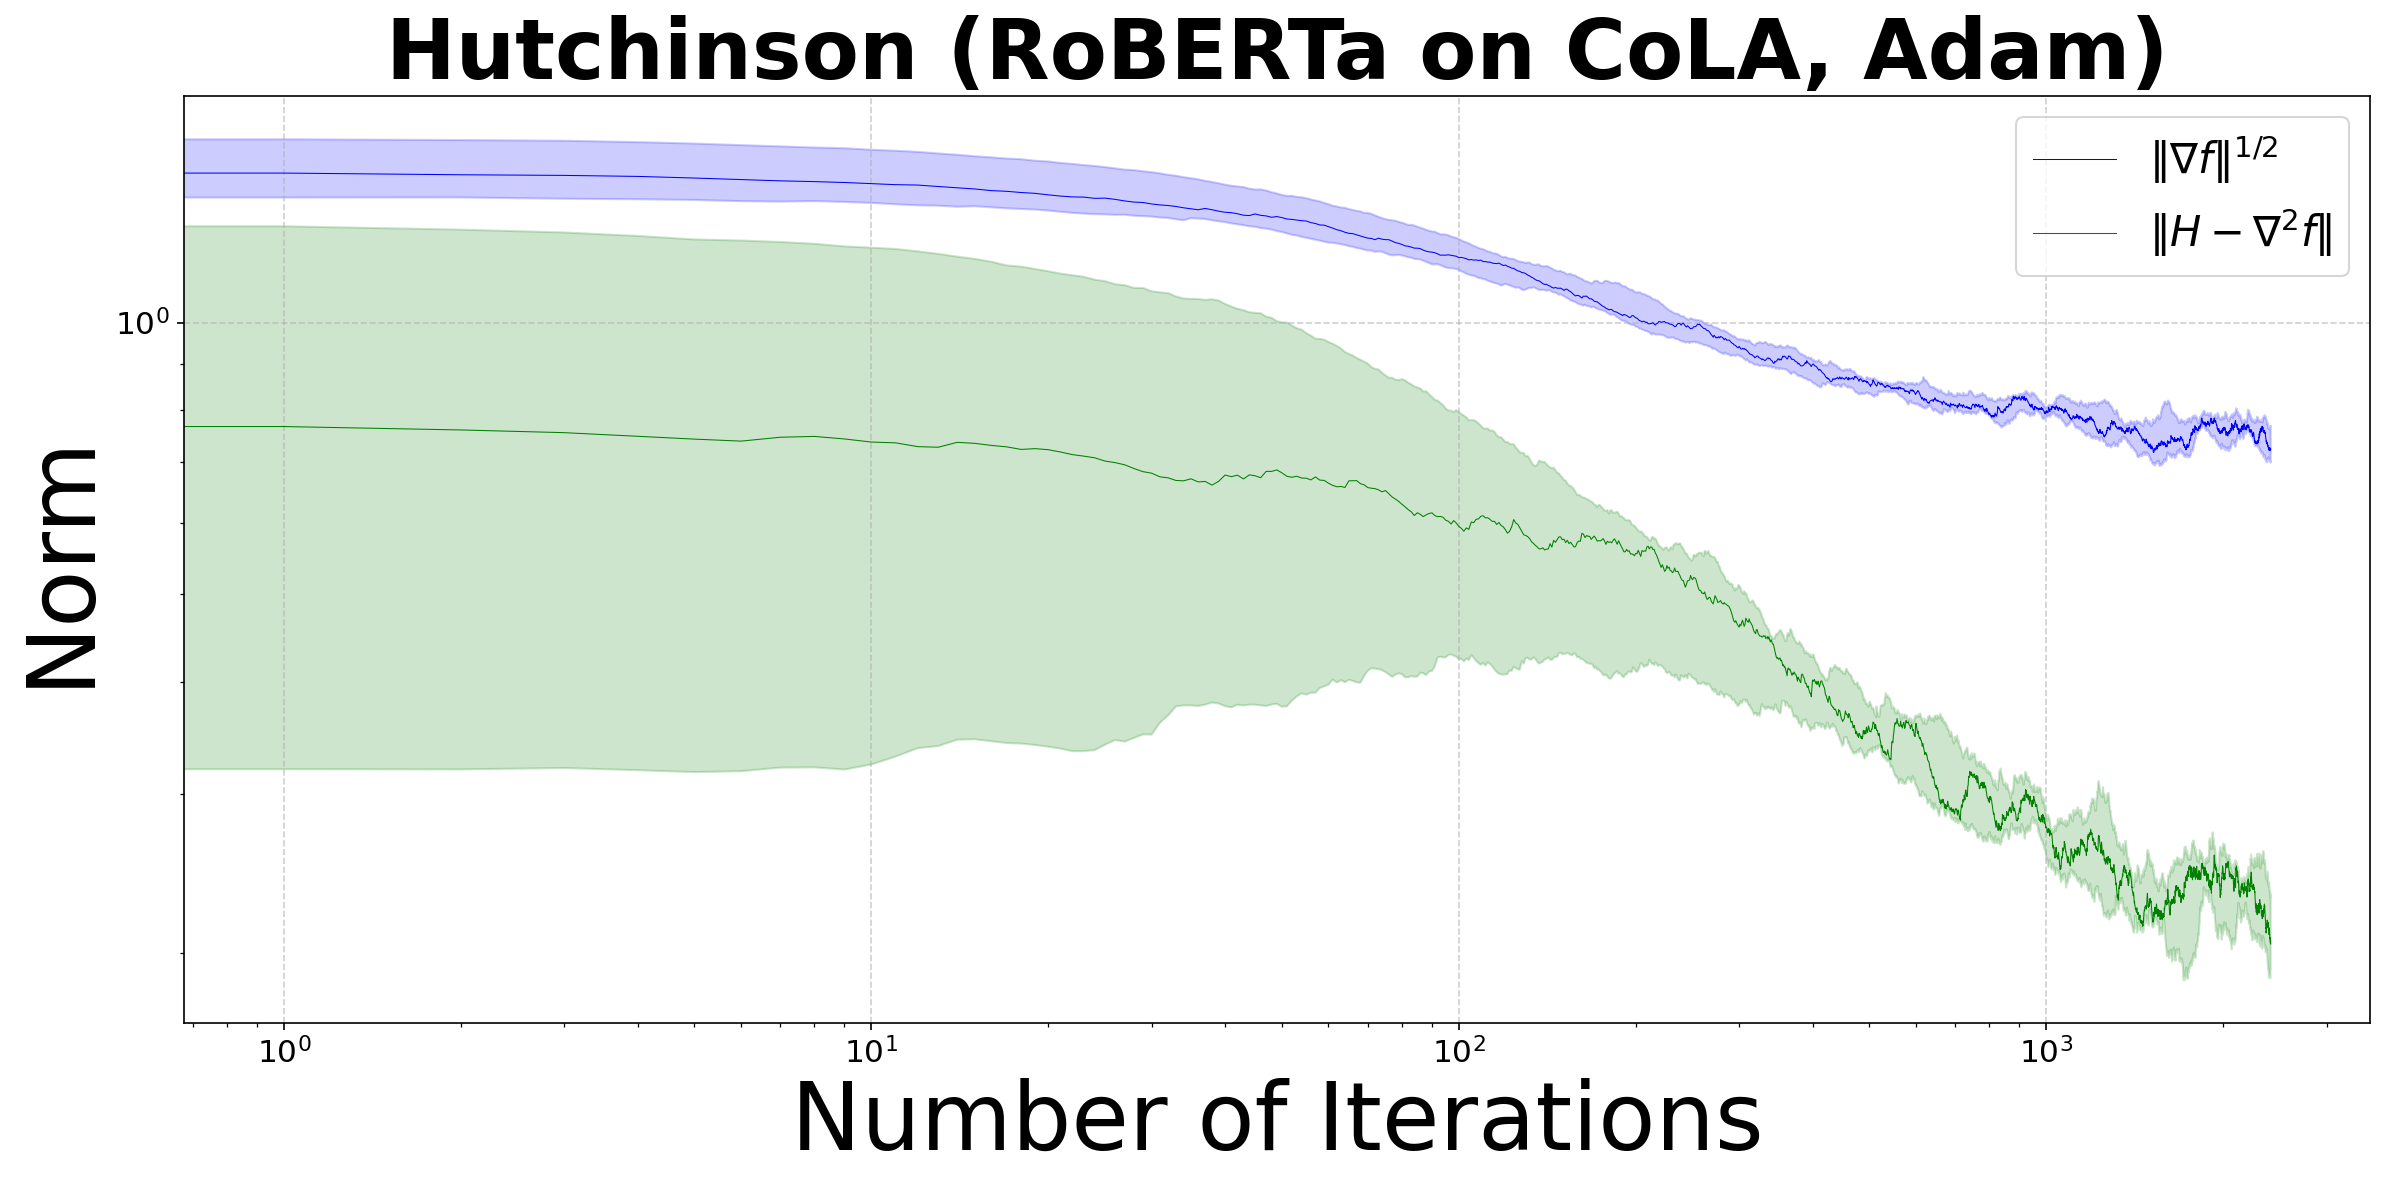

In [71]:
plot_norms(
    'roberta_cola_grad_norms.npy', 
    'roberta_cola_hutch_norms.npy', 
    'Hutchinson (RoBERTa on CoLA, Adam)',
    M_constant=1 / 30,
    plot_with_percentiles=True,
    logscale=True,
    )

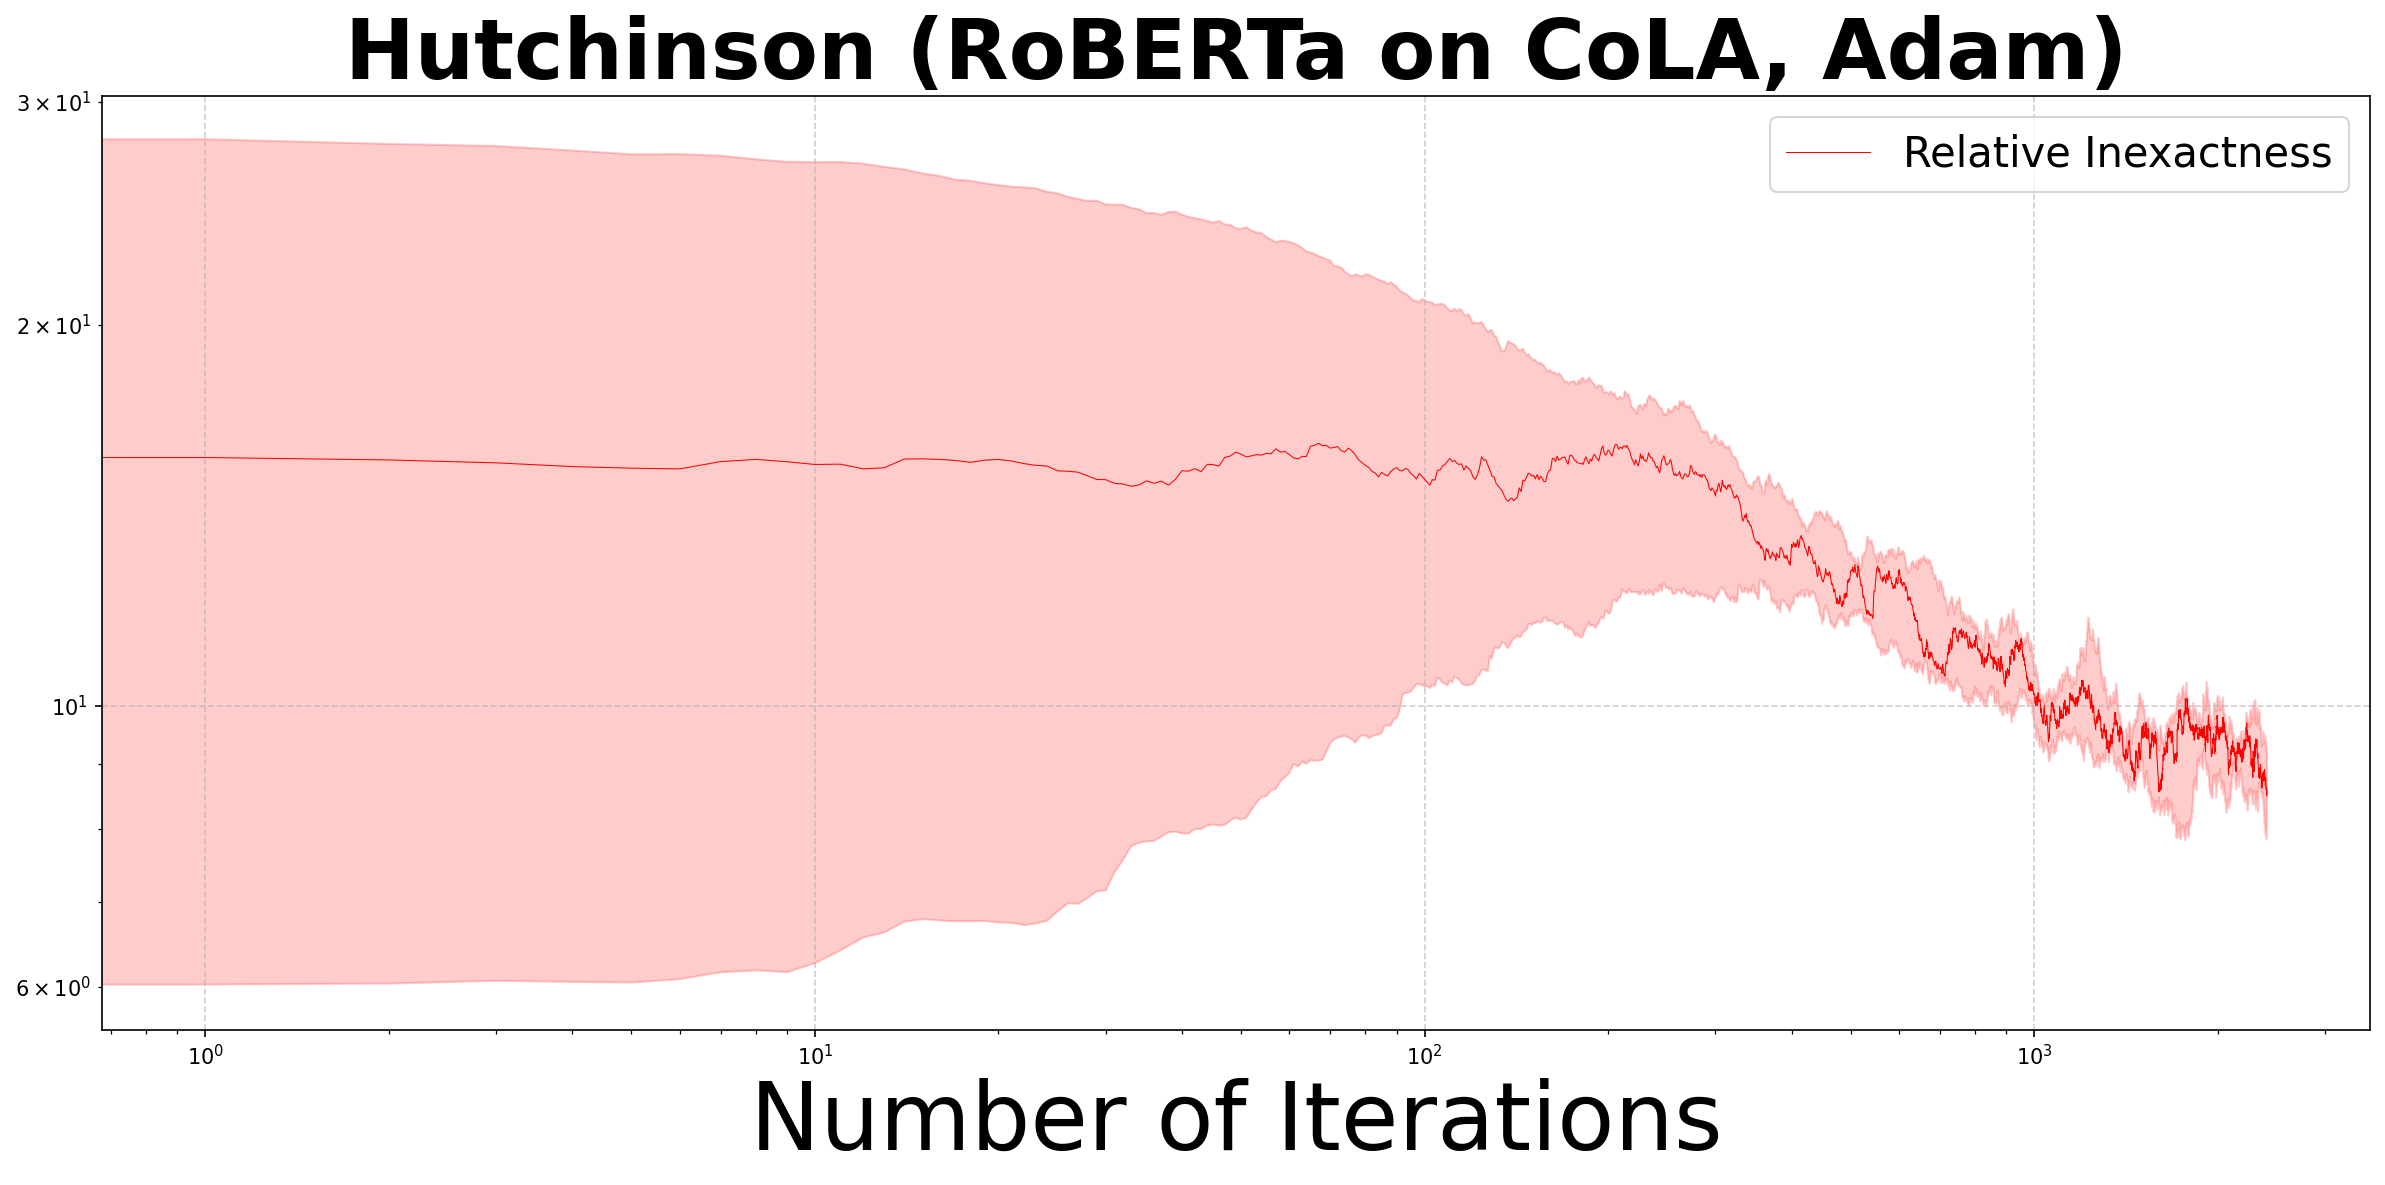

In [75]:
plot_relative_inexactness(
    'roberta_cola_grad_norms.npy', 
    'roberta_cola_hutch_norms.npy', 
    'Hutchinson (RoBERTa on CoLA, Adam)',
    M_constant=1,
    plot_with_percentiles=True,
    logscale=True,
    )

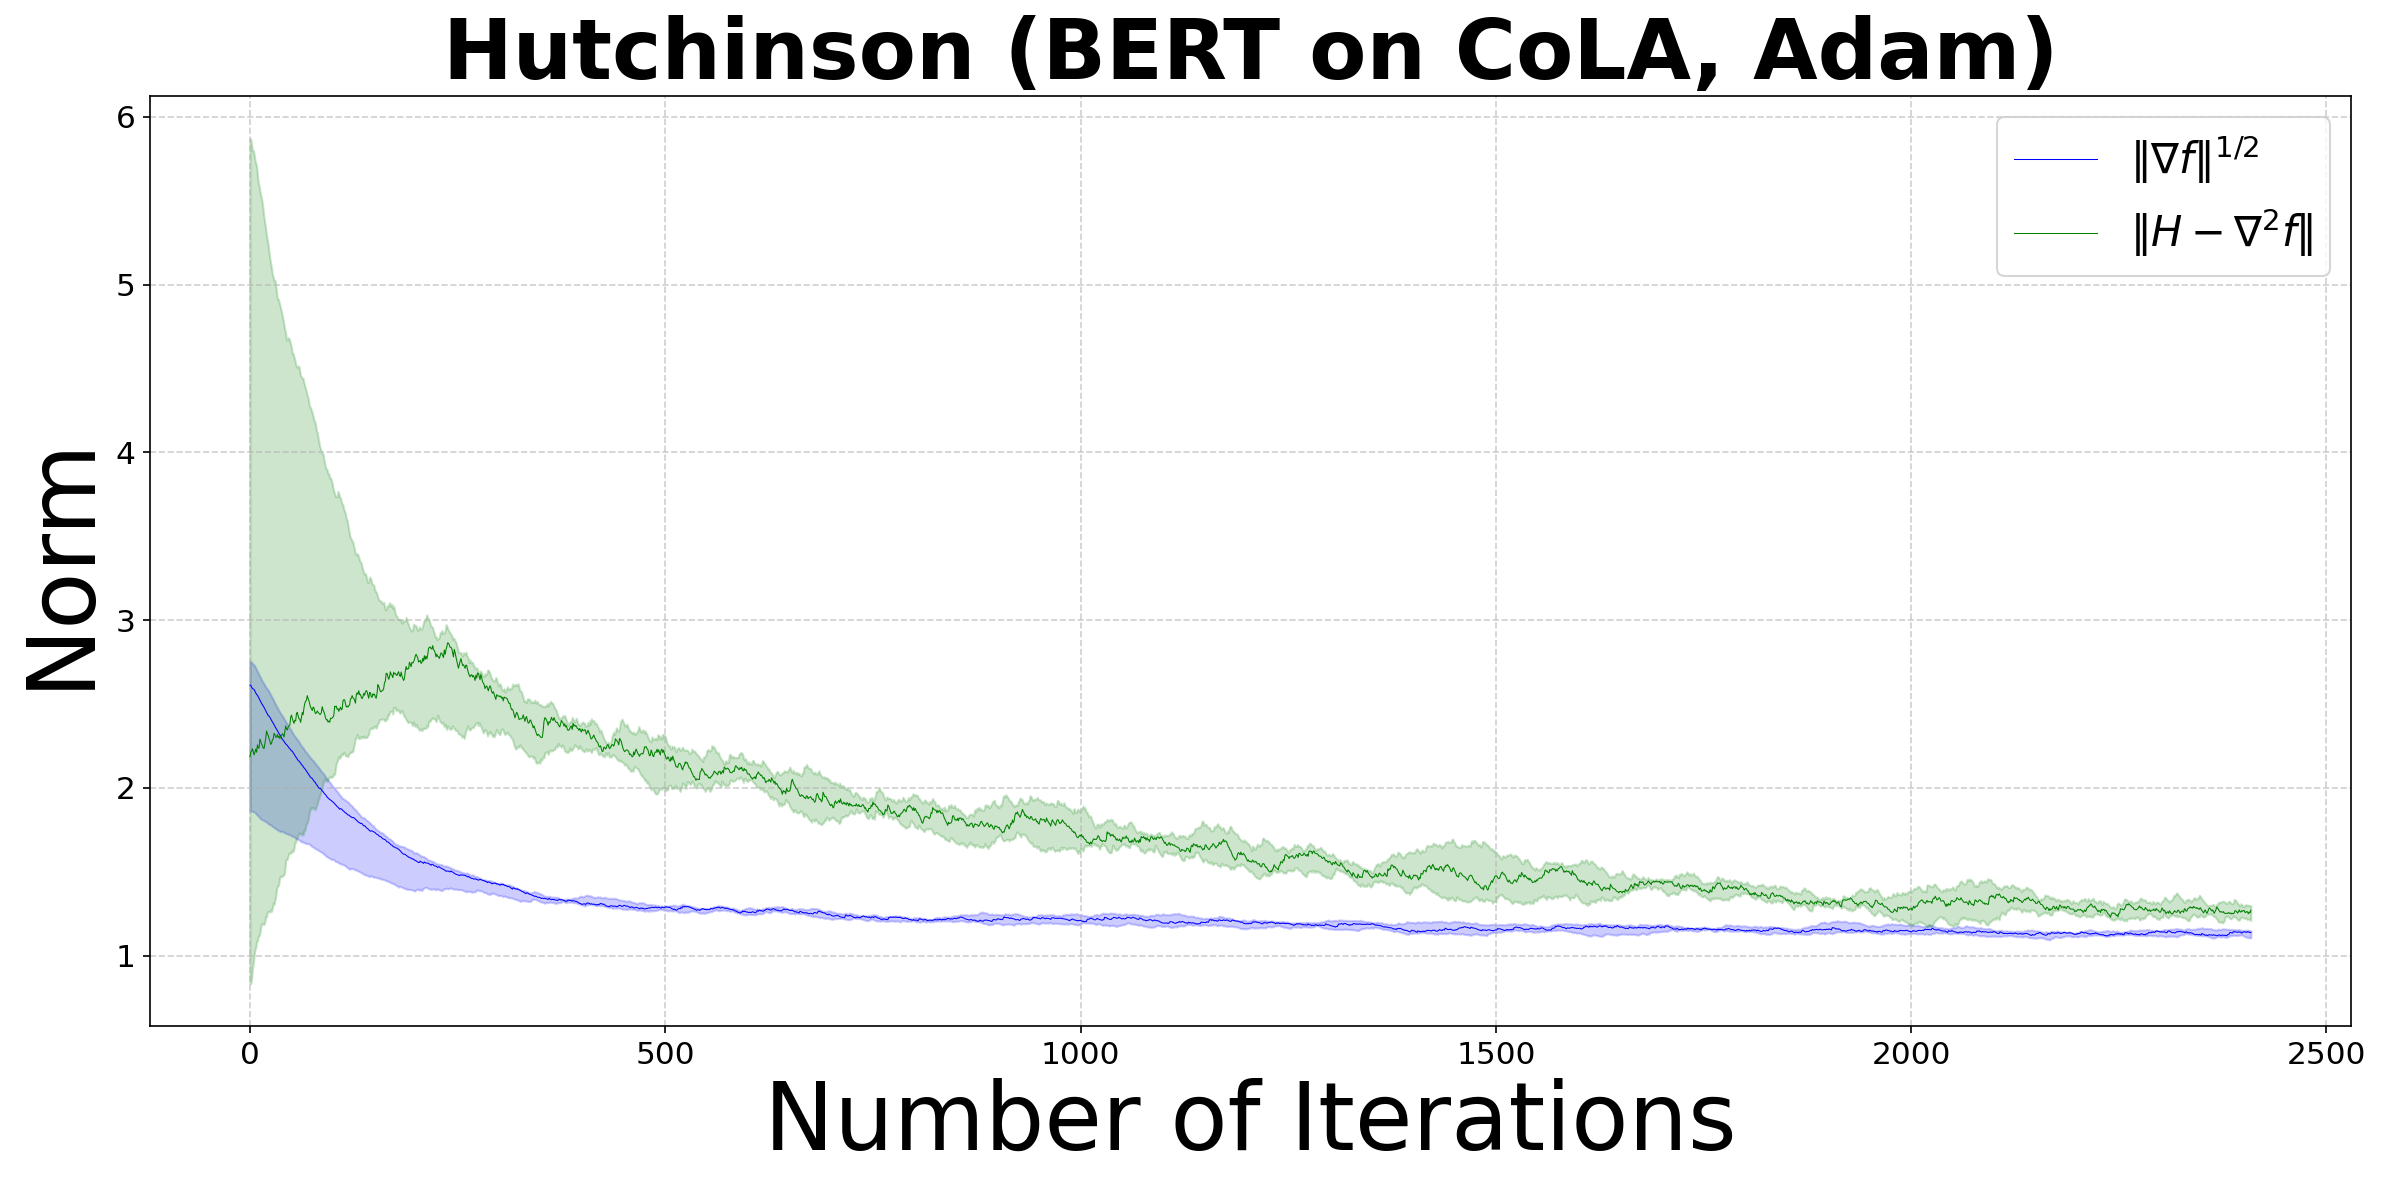

In [78]:
plot_norms(
    'bert_cola_grad_norms.npy', 
    'bert_cola_hutch_norms.npy', 
    'Hutchinson (BERT on CoLA, Adam)',
    M_constant=1 / 30,
    plot_with_percentiles=True,
    logscale=False,
    )

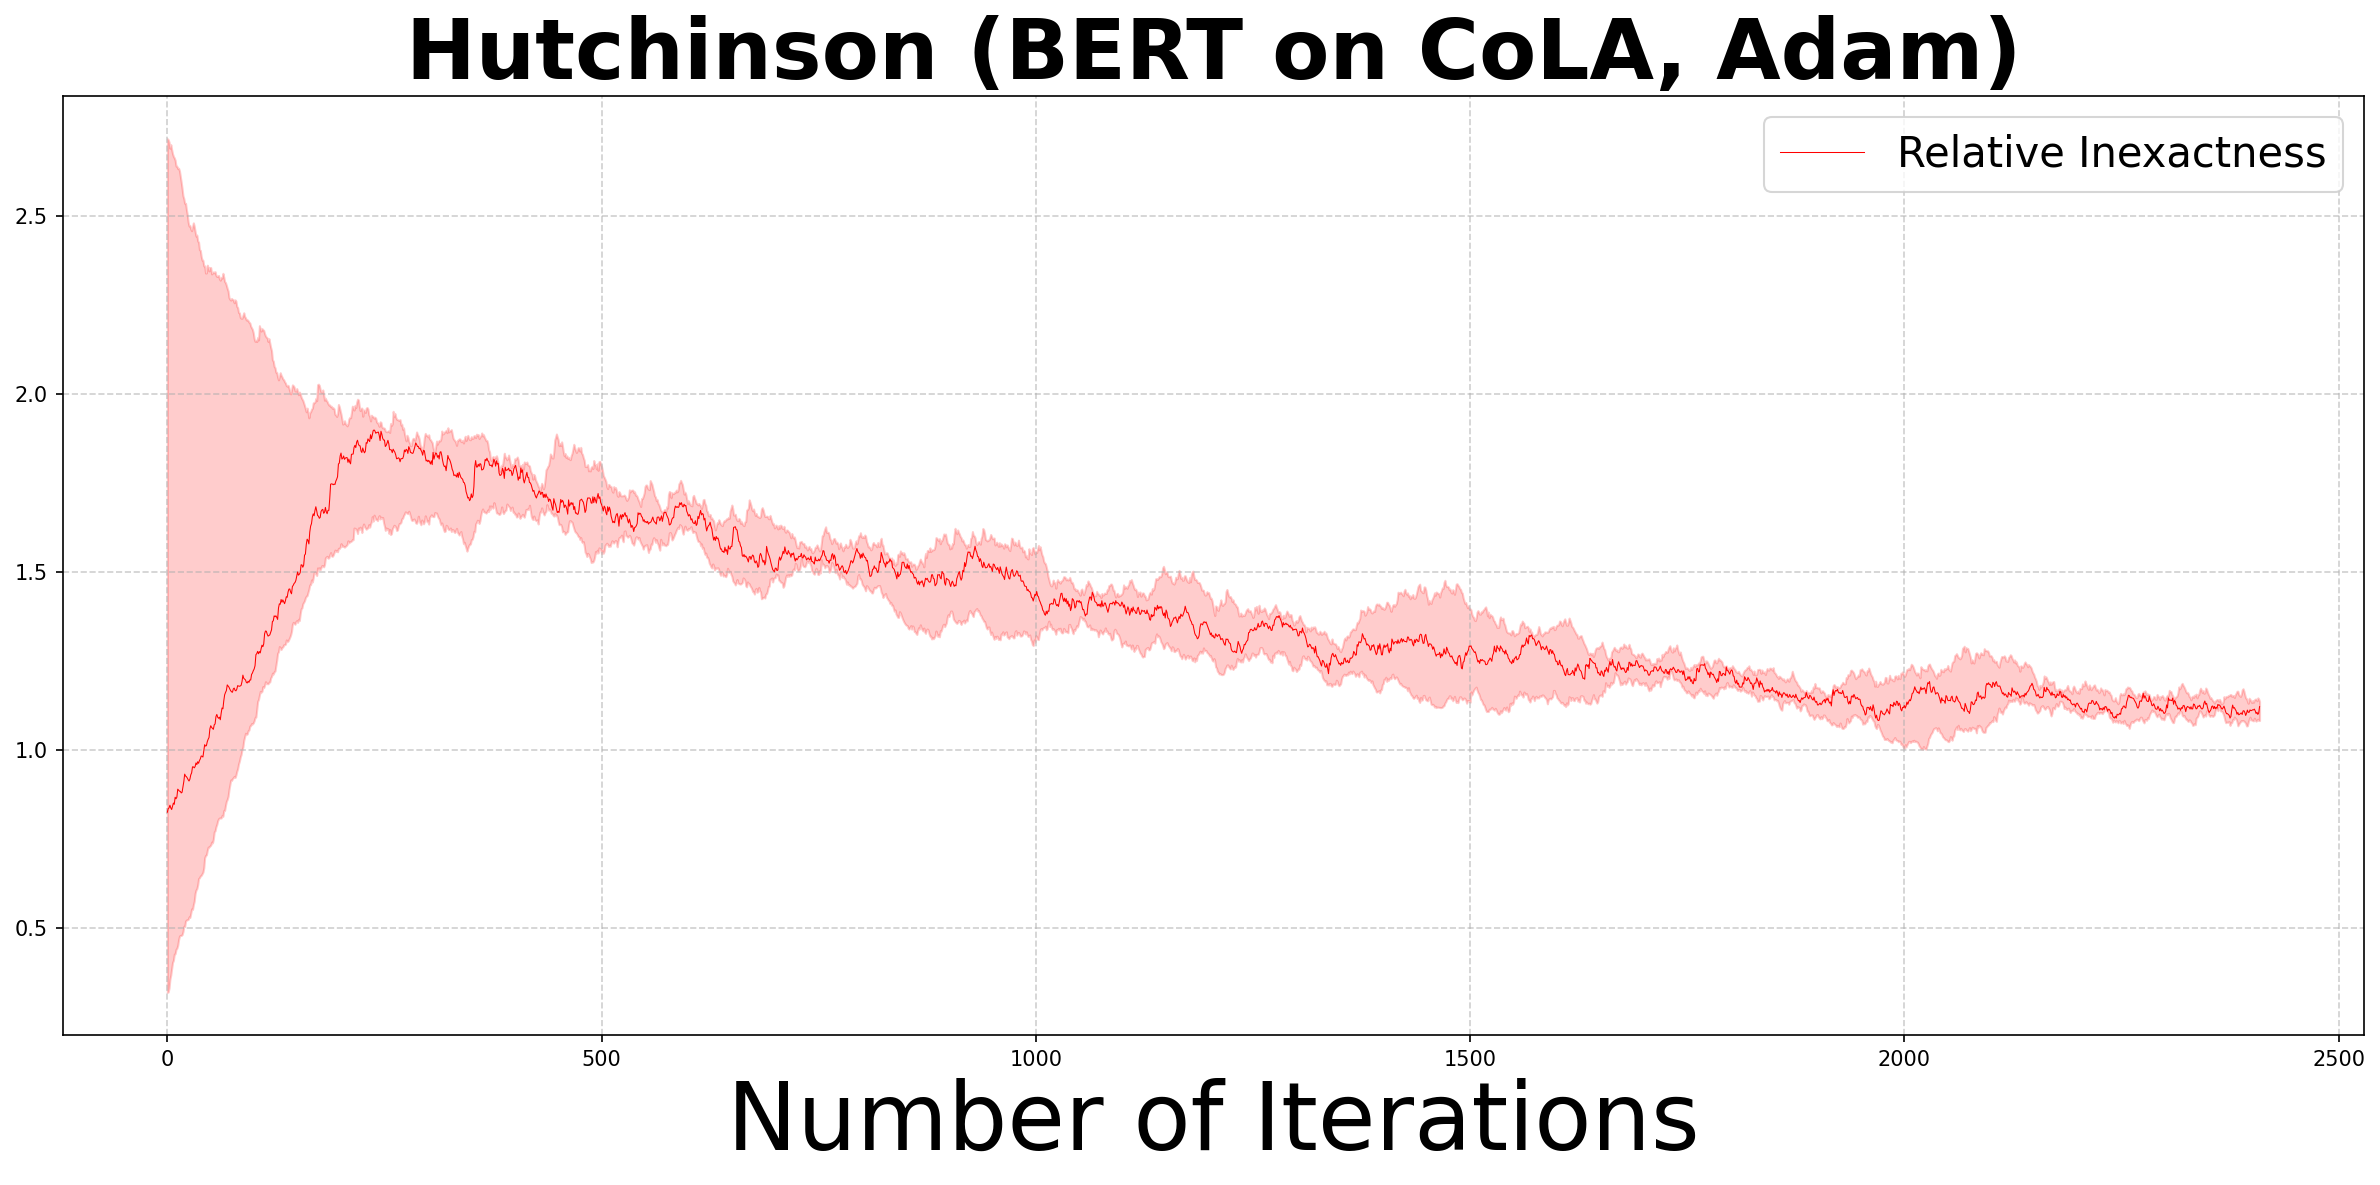

In [79]:
plot_relative_inexactness(
    'bert_cola_grad_norms.npy', 
    'bert_cola_hutch_norms.npy', 
    'Hutchinson (BERT on CoLA, Adam)',
    M_constant=1 / 30,
    plot_with_percentiles=True,
    logscale=False,
    )